In [1]:
import pandas as pd
import os
import librosa
import numpy as np
import tensorflow as tf
from tensorflow import  keras
from tensorflow.keras import layers, models

In [2]:
df =pd.read_csv("dataset_file_directory.csv")


In [3]:
p2_datasets =df[df['Participant']== 'P02']
# 

In [4]:
classess=p2_datasets['Label'].value_counts()

In [5]:
classess

social          247
affectionate    126
frustrated       56
delighted        43
laughter         38
selftalk         34
request          13
Name: Label, dtype: int64

In [6]:
p2_datasets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 557 entries, 1708 to 2264
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Filename     557 non-null    object
 1   Participant  557 non-null    object
 2   Label        557 non-null    object
dtypes: object(3)
memory usage: 17.4+ KB


In [7]:
# Specify the directory where your Python script is located
script_dir = r"C:\Users\pawan\Desktop\mv\downloaddataset"
# Define the relative path to the WAV files directory
wav_dir = os.path.join(script_dir, "downloaded_wav_files")

In [8]:
def extract_audio_features(dataset):
    null_file = 0
    
    for index, row in dataset.iterrows():
        filename = row['Filename']
        participant = row['Participant']
        label = row['Label']
        wav_file_path = os.path.join(wav_dir, filename)

        # Check if the audio file exists before attempting to load it
        if os.path.exists(wav_file_path):
            try:
                # Load the WAV file using librosa
                audio_data, sample_rate = librosa.load(wav_file_path, sr=None) 
                # Perform feature extraction (e.g., MFCCs)
                mfccs = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=50)
                chroma = librosa.feature.chroma_stft(y=audio_data, sr=sample_rate)
                spectral_contrast = librosa.feature.spectral_contrast(y=audio_data, sr=sample_rate)
                mel_spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate, n_mels=13)
                stft = librosa.stft(audio_data)
                fft_features = np.abs(stft)
                rmse = librosa.feature.rms(y=audio_data)
                
                fft_features_db = librosa.amplitude_to_db(fft_features, ref=np.max)

            # Calculate the mean of FFT features
                fft_features_mean = np.mean(fft_features_db, axis=1)
                rmse_mean = np.mean(rmse)
                mfccs_mean = np.mean(mfccs, axis=1)
                chroma_mean = np.mean(chroma, axis=1)
                spectral_contrast_mean = np.mean(spectral_contrast, axis=1)
                mel_spectrogram_mean = np.mean(mel_spectrogram, axis=1)
                
                # Combine the extracted features into a single vector
                combined_mmcs=np.hstack((mfccs_mean,mel_spectrogram_mean,chroma_mean,spectral_contrast_mean))
                combined_feature_vector = np.hstack((mfccs_mean, chroma_mean, spectral_contrast_mean, mel_spectrogram_mean, fft_features_mean, rmse_mean))
                mf_mel=np.hstack((mfccs_mean,mel_spectrogram_mean))
                mf_co=np.hstack((mfccs_mean,chroma_mean))
                mf_ch=np.hstack((mfccs_mean,spectral_contrast_mean))
                # Append the extracted features and label to the lists
                mf_ch_list.append(mf_mel)
                mf_co_list.append(mf_ch)
                mf_mel_list.append(mf_co)
                mfcc_fe.append(mfccs_mean)
                rmse_fe.append(rmse_mean)
                chroma_fe.append(chroma_mean)
                spectral_constrast_fe.append(spectral_contrast_mean)
                mel_spectrogram_fe.append(mel_spectrogram_mean)
                fft_fe.append(fft_features_mean)
                combined_4.append(combined_mmcs)
                combined_fe.append(combined_feature_vector)
                labels_list.append(label)

            except Exception as e:
                print(f"Error processing {wav_file_path}: {str(e)}")
        else:
            null_file += 1
            print(f"Audio file not found: {wav_file_path}")

    print("Related audio files not found count:", null_file)

    return null_file


In [9]:
mfcc_fe=[]
rmse_fe=[]
chroma_fe=[]
spectral_constrast_fe=[]
mel_spectrogram_fe=[]
fft_fe=[]

#fusion of mfcc+mel,fusion of mfcc + contrast,mfcc+chroma
mf_ch_list=[]
mf_co_list=[]
mf_mel_list=[]
combined_4=[]
labels_list=[]
combined_fe=[]
extract_audio_features(p2_datasets)


Related audio files not found count: 0


0

In [10]:
X_mfcc_fe  = np.array(mfcc_fe)
X_rmse_fe  = np.array(rmse_fe)
X_chroma_fe  = np.array(chroma_fe)
X_spectral_constrast_fe= np.array(spectral_constrast_fe)
X_mel_spectrogram_fe= np.array(mel_spectrogram_fe)
X_fft_fe= np.array(fft_fe)

X_mf_ch=np.array(mf_ch_list)
X_mf_co=np.array(mf_co_list)
X_mf_mel=np.array(mf_mel_list)
X_combined=np.array(combined_4)

y=np.array(labels_list)

In [11]:
X_mel_spectrogram_fe.shape

(557, 13)

In [12]:
# Encode the labels
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)


X_train_mfccs, X_test_mfccs, y_train1, y_test1 = train_test_split(X_mfcc_fe, y_encoded, test_size=0.2, random_state=42)
X_train_chroma, X_test_chroma, _, _ = train_test_split(X_chroma_fe, y_encoded, test_size=0.2, random_state=42)
X_train_spectral_contrast, X_test_spectral_contrast, _, _ = train_test_split(X_spectral_constrast_fe, y_encoded, test_size=0.2, random_state=42)
X_train_mel_spectrogram, X_test_mel_spectrogram, _, _ = train_test_split(X_mel_spectrogram_fe, y_encoded, test_size=0.2, random_state=42)
X_train_fft, X_test_fft, _, _ = train_test_split(X_fft_fe, y_encoded, test_size=0.2, random_state=42)
X_train_rmse, X_test_rmse, _, _ = train_test_split(X_rmse_fe, y_encoded, test_size=0.2, random_state=42)

X_mf_ch_train, X_mf_ch_test, _,_ = train_test_split(X_mf_ch, y_encoded, test_size=0.2, random_state=42)
X_mf_co_train, X_mf_co_test, _, _ = train_test_split(X_mf_co, y_encoded, test_size=0.2, random_state=42)
X_mf_mel_train, X_mf_mel_test, _, _ = train_test_split(X_mf_mel, y_encoded, test_size=0.2, random_state=42)
X_combined_train, X_combined_test, _, _ = train_test_split(X_combined, y_encoded, test_size=0.2, random_state=42)



In [13]:
import tensorflow as tf
from tensorflow.keras import layers, models
def cnn_model(X_train,y_train,X_test,y_test):
    n_classes=p2_datasets['Label'].nunique()
    model = models.Sequential([
        layers.Reshape((X_train.shape[1], 1), input_shape=(X_train.shape[1],)),
    
        # Add more convolutional layers
        layers.Conv1D(64, 3, activation='relu', padding='same'),
        layers.MaxPooling1D(2),
    
        layers.Conv1D(128, 3, activation='relu', padding='same'),
        layers.MaxPooling1D(2),
    
        layers.Conv1D(256, 3, activation='relu', padding='same'),
        layers.MaxPooling1D(2),
    
        layers.Flatten(),
    
        # Add more dense layers
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),  # Dropout layer to reduce overfitting
    
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
    
        layers.Dense(n_classes, activation='softmax') 
    ])
    model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=50, 
                   validation_split=0.2, 
                    batch_size=45)
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    accuracy_stack.append(test_accuracy)
    print(f"Test accuracy: {test_accuracy}")
    
    return model


def create_cnn_model(input_shape, num_classes):
    model = keras.Sequential([
        layers.Reshape((input_shape, 1), input_shape=(input_shape, )),  # Reshape for 1D convolution

        # Convolutional layers
        layers.Conv1D(64, 3, activation='relu', padding='same'),
        layers.Conv1D(128, 3, activation='relu', padding='same'),
        layers.Conv1D(256, 3, activation='relu', padding='same'),

        # Flatten layer
        layers.Flatten(),

        # Fully connected layers
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),

        # Output layer
        layers.Dense(num_classes, activation='softmax')
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

In [14]:
accuracy_stack=[]

In [15]:

cnn_model(X_train_mfccs,y_train1,X_test_mfccs,y_test1)

Epoch 1/50
8/8 [==============================] - 1s 67ms/step - loss: 6.3378 - accuracy: 0.2022 - val_loss: 1.7166 - val_accuracy: 0.3933
Epoch 2/50
8/8 [==============================] - 0s 16ms/step - loss: 2.1478 - accuracy: 0.2865 - val_loss: 1.6425 - val_accuracy: 0.3933
Epoch 3/50
8/8 [==============================] - 0s 15ms/step - loss: 1.7016 - accuracy: 0.3820 - val_loss: 1.6236 - val_accuracy: 0.3933
Epoch 4/50
8/8 [==============================] - 0s 16ms/step - loss: 1.6925 - accuracy: 0.3652 - val_loss: 1.5943 - val_accuracy: 0.3933
Epoch 5/50
8/8 [==============================] - 0s 16ms/step - loss: 1.6628 - accuracy: 0.4073 - val_loss: 1.5952 - val_accuracy: 0.3933
Epoch 6/50
8/8 [==============================] - 0s 17ms/step - loss: 1.6375 - accuracy: 0.3933 - val_loss: 1.5933 - val_accuracy: 0.3933
Epoch 7/50
8/8 [==============================] - 0s 16ms/step - loss: 1.6219 - accuracy: 0.4185 - val_loss: 1.5589 - val_accuracy: 0.4270
Epoch 8/50
8/8 [===========

In [16]:
cnn_model(X_train_chroma,y_train1,X_test_chroma,y_test1)

Epoch 1/50
8/8 [==============================] - 1s 59ms/step - loss: 1.8631 - accuracy: 0.3483 - val_loss: 1.6909 - val_accuracy: 0.3933
Epoch 2/50
8/8 [==============================] - 0s 13ms/step - loss: 1.6674 - accuracy: 0.4213 - val_loss: 1.6297 - val_accuracy: 0.3933
Epoch 3/50
8/8 [==============================] - 0s 14ms/step - loss: 1.6311 - accuracy: 0.4354 - val_loss: 1.6359 - val_accuracy: 0.3933
Epoch 4/50
8/8 [==============================] - 0s 16ms/step - loss: 1.6168 - accuracy: 0.4298 - val_loss: 1.6187 - val_accuracy: 0.3933
Epoch 5/50
8/8 [==============================] - 0s 16ms/step - loss: 1.5921 - accuracy: 0.4298 - val_loss: 1.6169 - val_accuracy: 0.3933
Epoch 6/50
8/8 [==============================] - 0s 15ms/step - loss: 1.5316 - accuracy: 0.4438 - val_loss: 1.6181 - val_accuracy: 0.3933
Epoch 7/50
8/8 [==============================] - 0s 12ms/step - loss: 1.6007 - accuracy: 0.4326 - val_loss: 1.6181 - val_accuracy: 0.3933
Epoch 8/50
8/8 [===========

In [17]:
cnn_model(X_train_mel_spectrogram,y_train1,X_test_mel_spectrogram,y_test1)

Epoch 1/50
8/8 [==============================] - 1s 59ms/step - loss: 2.0343 - accuracy: 0.2697 - val_loss: 1.6337 - val_accuracy: 0.3933
Epoch 2/50
8/8 [==============================] - 0s 13ms/step - loss: 1.8835 - accuracy: 0.3230 - val_loss: 1.6048 - val_accuracy: 0.4157
Epoch 3/50
8/8 [==============================] - 0s 12ms/step - loss: 1.7830 - accuracy: 0.3736 - val_loss: 1.6000 - val_accuracy: 0.3933
Epoch 4/50
8/8 [==============================] - 0s 11ms/step - loss: 1.7092 - accuracy: 0.3680 - val_loss: 1.5926 - val_accuracy: 0.3820
Epoch 5/50
8/8 [==============================] - 0s 12ms/step - loss: 1.6527 - accuracy: 0.4326 - val_loss: 1.5618 - val_accuracy: 0.3933
Epoch 6/50
8/8 [==============================] - 0s 12ms/step - loss: 1.6343 - accuracy: 0.4298 - val_loss: 1.5605 - val_accuracy: 0.3820
Epoch 7/50
8/8 [==============================] - 0s 13ms/step - loss: 1.6493 - accuracy: 0.4017 - val_loss: 1.5622 - val_accuracy: 0.3933
Epoch 8/50
8/8 [===========

In [18]:

cnn_model(X_train_fft, y_train1, X_test_fft, y_test1)


Epoch 1/50
8/8 [==============================] - 2s 177ms/step - loss: 16.9591 - accuracy: 0.2360 - val_loss: 1.7831 - val_accuracy: 0.3933
Epoch 2/50
8/8 [==============================] - 1s 128ms/step - loss: 2.2167 - accuracy: 0.2893 - val_loss: 1.6667 - val_accuracy: 0.3933
Epoch 3/50
8/8 [==============================] - 1s 130ms/step - loss: 1.7166 - accuracy: 0.3904 - val_loss: 1.6186 - val_accuracy: 0.3933
Epoch 4/50
8/8 [==============================] - 1s 132ms/step - loss: 1.7626 - accuracy: 0.3511 - val_loss: 1.6298 - val_accuracy: 0.3933
Epoch 5/50
8/8 [==============================] - 1s 130ms/step - loss: 1.7084 - accuracy: 0.3989 - val_loss: 1.6602 - val_accuracy: 0.3933
Epoch 6/50
8/8 [==============================] - 1s 125ms/step - loss: 1.6369 - accuracy: 0.4242 - val_loss: 1.6426 - val_accuracy: 0.3933
Epoch 7/50
8/8 [==============================] - 1s 139ms/step - loss: 1.6341 - accuracy: 0.3904 - val_loss: 1.6234 - val_accuracy: 0.3933
Epoch 8/50
8/8 [===

In [19]:
X_train_rmse.shape


(445,)

In [20]:

model2=create_cnn_model(1,7)
history = model2.fit(X_train_rmse, y_train1, epochs=10, 
                   validation_split=0.2, 
                    batch_size=45)

test_loss, test_accuracy = model2.evaluate(X_test_rmse, y_test1)

accuracy_stack.append(test_accuracy)
print(f"Test accuracy: {test_accuracy}")

Epoch 1/10
8/8 [==============================] - 1s 56ms/step - loss: 1.9224 - accuracy: 0.3876 - val_loss: 1.8849 - val_accuracy: 0.3933
Epoch 2/10
8/8 [==============================] - 0s 13ms/step - loss: 1.8088 - accuracy: 0.4354 - val_loss: 1.7232 - val_accuracy: 0.3933
Epoch 3/10
8/8 [==============================] - 0s 11ms/step - loss: 1.6405 - accuracy: 0.4354 - val_loss: 1.6916 - val_accuracy: 0.3933
Epoch 4/10
8/8 [==============================] - 0s 11ms/step - loss: 1.6096 - accuracy: 0.4298 - val_loss: 1.6343 - val_accuracy: 0.3933
Epoch 5/10
8/8 [==============================] - 0s 11ms/step - loss: 1.5878 - accuracy: 0.4129 - val_loss: 1.6309 - val_accuracy: 0.3933
Epoch 6/10
8/8 [==============================] - 0s 11ms/step - loss: 1.5853 - accuracy: 0.4157 - val_loss: 1.6239 - val_accuracy: 0.3933
Epoch 7/10
8/8 [==============================] - 0s 11ms/step - loss: 1.5898 - accuracy: 0.3989 - val_loss: 1.6239 - val_accuracy: 0.3933
Epoch 8/10
8/8 [===========

In [21]:


model1=create_cnn_model(7,7)
history = model1.fit(X_train_spectral_contrast, y_train1, epochs=10, 
                   validation_split=0.2, 
                    batch_size=45)

test_loss, test_accuracy = model1.evaluate(X_test_spectral_contrast, y_test1)

accuracy_stack.append(test_accuracy)
print(f"Test accuracy: {test_accuracy}")


Epoch 1/10
8/8 [==============================] - 1s 58ms/step - loss: 2.2927 - accuracy: 0.2500 - val_loss: 1.6458 - val_accuracy: 0.3933
Epoch 2/10
8/8 [==============================] - 0s 16ms/step - loss: 1.6978 - accuracy: 0.3764 - val_loss: 1.6556 - val_accuracy: 0.3933
Epoch 3/10
8/8 [==============================] - 0s 14ms/step - loss: 1.6803 - accuracy: 0.4129 - val_loss: 1.6586 - val_accuracy: 0.3933
Epoch 4/10
8/8 [==============================] - 0s 13ms/step - loss: 1.6476 - accuracy: 0.4073 - val_loss: 1.6460 - val_accuracy: 0.3933
Epoch 5/10
8/8 [==============================] - 0s 16ms/step - loss: 1.6327 - accuracy: 0.4129 - val_loss: 1.6317 - val_accuracy: 0.3933
Epoch 6/10
8/8 [==============================] - 0s 13ms/step - loss: 1.6043 - accuracy: 0.4354 - val_loss: 1.6295 - val_accuracy: 0.3933
Epoch 7/10
8/8 [==============================] - 0s 16ms/step - loss: 1.6408 - accuracy: 0.4270 - val_loss: 1.6314 - val_accuracy: 0.3933
Epoch 8/10
8/8 [===========

In [22]:
cnn_model(X_mf_ch_train,y_train1,X_mf_ch_test,y_test1)

Epoch 1/50
8/8 [==============================] - 1s 64ms/step - loss: 4.3337 - accuracy: 0.2584 - val_loss: 1.6321 - val_accuracy: 0.4045
Epoch 2/50
8/8 [==============================] - 0s 18ms/step - loss: 1.9766 - accuracy: 0.2978 - val_loss: 1.6762 - val_accuracy: 0.3820
Epoch 3/50
8/8 [==============================] - 0s 20ms/step - loss: 1.8131 - accuracy: 0.3230 - val_loss: 1.6266 - val_accuracy: 0.3933
Epoch 4/50
8/8 [==============================] - 0s 18ms/step - loss: 1.7354 - accuracy: 0.3736 - val_loss: 1.6855 - val_accuracy: 0.4045
Epoch 5/50
8/8 [==============================] - 0s 18ms/step - loss: 1.7121 - accuracy: 0.3596 - val_loss: 1.5869 - val_accuracy: 0.4045
Epoch 6/50
8/8 [==============================] - 0s 18ms/step - loss: 1.6333 - accuracy: 0.4213 - val_loss: 1.5766 - val_accuracy: 0.3933
Epoch 7/50
8/8 [==============================] - 0s 18ms/step - loss: 1.6425 - accuracy: 0.3820 - val_loss: 1.6008 - val_accuracy: 0.3933
Epoch 8/50
8/8 [===========

In [23]:
cnn_model(X_mf_co_train,y_train1,X_mf_co_test,y_test1)

Epoch 1/50
8/8 [==============================] - 1s 69ms/step - loss: 3.9317 - accuracy: 0.2640 - val_loss: 1.7118 - val_accuracy: 0.3933
Epoch 2/50
8/8 [==============================] - 0s 20ms/step - loss: 1.9395 - accuracy: 0.3034 - val_loss: 1.6675 - val_accuracy: 0.3933
Epoch 3/50
8/8 [==============================] - 0s 18ms/step - loss: 1.7291 - accuracy: 0.3567 - val_loss: 1.6316 - val_accuracy: 0.3933
Epoch 4/50
8/8 [==============================] - 0s 18ms/step - loss: 1.6496 - accuracy: 0.3904 - val_loss: 1.6101 - val_accuracy: 0.3933
Epoch 5/50
8/8 [==============================] - 0s 16ms/step - loss: 1.7273 - accuracy: 0.3904 - val_loss: 1.6343 - val_accuracy: 0.4045
Epoch 6/50
8/8 [==============================] - 0s 17ms/step - loss: 1.6584 - accuracy: 0.3904 - val_loss: 1.6168 - val_accuracy: 0.3933
Epoch 7/50
8/8 [==============================] - 0s 18ms/step - loss: 1.6782 - accuracy: 0.4045 - val_loss: 1.5926 - val_accuracy: 0.4045
Epoch 8/50
8/8 [===========

In [24]:
cnn_model(X_mf_mel_train,y_train1,X_mf_mel_test,y_test1)

Epoch 1/50
8/8 [==============================] - 1s 65ms/step - loss: 5.5127 - accuracy: 0.2416 - val_loss: 1.6579 - val_accuracy: 0.3933
Epoch 2/50
8/8 [==============================] - 0s 18ms/step - loss: 1.9222 - accuracy: 0.3427 - val_loss: 1.7350 - val_accuracy: 0.3933
Epoch 3/50
8/8 [==============================] - 0s 18ms/step - loss: 1.7106 - accuracy: 0.3736 - val_loss: 1.5921 - val_accuracy: 0.3933
Epoch 4/50
8/8 [==============================] - 0s 17ms/step - loss: 1.6934 - accuracy: 0.3792 - val_loss: 1.6031 - val_accuracy: 0.3933
Epoch 5/50
8/8 [==============================] - 0s 18ms/step - loss: 1.5986 - accuracy: 0.4298 - val_loss: 1.5862 - val_accuracy: 0.3933
Epoch 6/50
8/8 [==============================] - 0s 20ms/step - loss: 1.6429 - accuracy: 0.4185 - val_loss: 1.5906 - val_accuracy: 0.4157
Epoch 7/50
8/8 [==============================] - 0s 18ms/step - loss: 1.6347 - accuracy: 0.4270 - val_loss: 1.5553 - val_accuracy: 0.4719
Epoch 8/50
8/8 [===========

In [25]:
cnn_model(X_combined_train,y_train1,X_combined_test,y_test1)

Epoch 1/50
8/8 [==============================] - 1s 69ms/step - loss: 4.3719 - accuracy: 0.2528 - val_loss: 1.6356 - val_accuracy: 0.3933
Epoch 2/50
8/8 [==============================] - 0s 22ms/step - loss: 1.9867 - accuracy: 0.2809 - val_loss: 1.6300 - val_accuracy: 0.4382
Epoch 3/50
8/8 [==============================] - 0s 19ms/step - loss: 1.8444 - accuracy: 0.3090 - val_loss: 1.6737 - val_accuracy: 0.4045
Epoch 4/50
8/8 [==============================] - 0s 20ms/step - loss: 1.7239 - accuracy: 0.3483 - val_loss: 1.5961 - val_accuracy: 0.4045
Epoch 5/50
8/8 [==============================] - 0s 18ms/step - loss: 1.6537 - accuracy: 0.3961 - val_loss: 1.5964 - val_accuracy: 0.3933
Epoch 6/50
8/8 [==============================] - 0s 20ms/step - loss: 1.6480 - accuracy: 0.3989 - val_loss: 1.5526 - val_accuracy: 0.4045
Epoch 7/50
8/8 [==============================] - 0s 20ms/step - loss: 1.6145 - accuracy: 0.4101 - val_loss: 1.5832 - val_accuracy: 0.3820
Epoch 8/50
8/8 [===========

In [26]:
accuracy_stack

[0.5625,
 0.4375,
 0.5089285969734192,
 0.5535714030265808,
 0.5089285969734192,
 0.5089285969734192,
 0.5625,
 0.6071428656578064,
 0.5892857313156128,
 0.5625]

In [27]:
labels=p2_datasets['Label'].unique()

In [28]:
labels

array(['frustrated', 'social', 'selftalk', 'laughter', 'affectionate',
       'request', 'delighted'], dtype=object)

In [29]:
import time
import matplotlib.pyplot as plt
# Define a function to train and evaluate a CNN model
def train_evaluate_cnn_model(X_train, y_train, X_test, y_test, input_shape, num_classes, epochs=10):
    start_time = time.time()

    model = create_cnn_model(input_shape, num_classes)
    history = model.fit(X_train, y_train, epochs=epochs, validation_split=0.2, batch_size=45)
    test_loss, test_accuracy = model.evaluate(X_test, y_test)

    end_time = time.time()

    return model, history, test_accuracy, end_time - start_time

# List of models and their input shapes
models_to_evaluate = [
    (X_train_mfccs, y_train1, X_test_mfccs, y_test1, X_train_mfccs.shape[1], len(set(labels))),
    (X_train_chroma, y_train1, X_test_chroma, y_test1, X_train_chroma.shape[1], len(set(labels))),
    (X_train_mel_spectrogram, y_train1, X_test_mel_spectrogram, y_test1, X_train_mel_spectrogram.shape[1], len(set(labels))),
    (X_train_fft, y_train1, X_test_fft, y_test1, X_train_fft.shape[1], len(set(labels))),
    (X_train_rmse, y_train1, X_test_rmse, y_test1, 1, len(set(labels))),
    (X_train_spectral_contrast, y_train1, X_test_spectral_contrast, y_test1,7, len(set(labels))),
    (X_mf_ch_train, y_train1, X_mf_ch_test, y_test1, X_mf_ch_train.shape[1], len(set(labels))),
    (X_mf_co_train, y_train1, X_mf_co_test, y_test1, X_mf_co_train.shape[1], len(set(labels))),
    (X_mf_mel_train, y_train1, X_mf_mel_test, y_test1, X_mf_mel_train.shape[1], len(set(labels))),
    (X_combined_train, y_train1, X_combined_test, y_test1, X_combined_train.shape[1], len(set(labels)))
]

# Train and evaluate models, and collect their accuracies and execution times
model_accuracies = []
execution_times = []

for X_train, y_train, X_test, y_test, input_shape, num_classes in models_to_evaluate:
    model, _, test_accuracy, execution_time = train_evaluate_cnn_model(X_train, y_train, X_test, y_test, input_shape, num_classes)
    model_accuracies.append(test_accuracy)
    execution_times.append(execution_time)



Epoch 1/10
8/8 [==============================] - 1s 76ms/step - loss: 4.3575 - accuracy: 0.2360 - val_loss: 1.6693 - val_accuracy: 0.3933
Epoch 2/10
8/8 [==============================] - 0s 36ms/step - loss: 1.8433 - accuracy: 0.3146 - val_loss: 1.6592 - val_accuracy: 0.3933
Epoch 3/10
8/8 [==============================] - 0s 37ms/step - loss: 1.7125 - accuracy: 0.3624 - val_loss: 1.6029 - val_accuracy: 0.4045
Epoch 4/10
8/8 [==============================] - 0s 32ms/step - loss: 1.6979 - accuracy: 0.3820 - val_loss: 1.6274 - val_accuracy: 0.4831
Epoch 5/10
8/8 [==============================] - 0s 31ms/step - loss: 1.6279 - accuracy: 0.4298 - val_loss: 1.5490 - val_accuracy: 0.4157
Epoch 6/10
8/8 [==============================] - 0s 37ms/step - loss: 1.5520 - accuracy: 0.4494 - val_loss: 1.5359 - val_accuracy: 0.4045
Epoch 7/10
8/8 [==============================] - 0s 32ms/step - loss: 1.5804 - accuracy: 0.4438 - val_loss: 1.5058 - val_accuracy: 0.4270
Epoch 8/10
8/8 [===========

Epoch 7/10
8/8 [==============================] - 0s 16ms/step - loss: 1.6397 - accuracy: 0.4157 - val_loss: 1.6300 - val_accuracy: 0.3933
Epoch 8/10
8/8 [==============================] - 0s 13ms/step - loss: 1.6507 - accuracy: 0.4242 - val_loss: 1.6291 - val_accuracy: 0.3933
Epoch 9/10
8/8 [==============================] - 0s 16ms/step - loss: 1.6024 - accuracy: 0.4101 - val_loss: 1.6237 - val_accuracy: 0.3933
Epoch 10/10
4/4 [==============================] - 0s 5ms/step - loss: 1.5820 - accuracy: 0.5089
Epoch 1/10
8/8 [==============================] - 1s 94ms/step - loss: 4.4314 - accuracy: 0.2612 - val_loss: 1.7018 - val_accuracy: 0.3933
Epoch 2/10
8/8 [==============================] - 0s 40ms/step - loss: 1.8034 - accuracy: 0.3511 - val_loss: 1.6591 - val_accuracy: 0.3933
Epoch 3/10
8/8 [==============================] - 0s 40ms/step - loss: 1.6832 - accuracy: 0.3904 - val_loss: 1.5876 - val_accuracy: 0.3933
Epoch 4/10
8/8 [==============================] - 0s 40ms/step - loss

In [30]:
print(model_accuracies)
print(" ")
print(accuracy_stack)

[0.5357142686843872, 0.5089285969734192, 0.5357142686843872, 0.5089285969734192, 0.5089285969734192, 0.5089285969734192, 0.5714285969734192, 0.5267857313156128, 0.5714285969734192, 0.5535714030265808]
 
[0.5625, 0.4375, 0.5089285969734192, 0.5535714030265808, 0.5089285969734192, 0.5089285969734192, 0.5625, 0.6071428656578064, 0.5892857313156128, 0.5625]


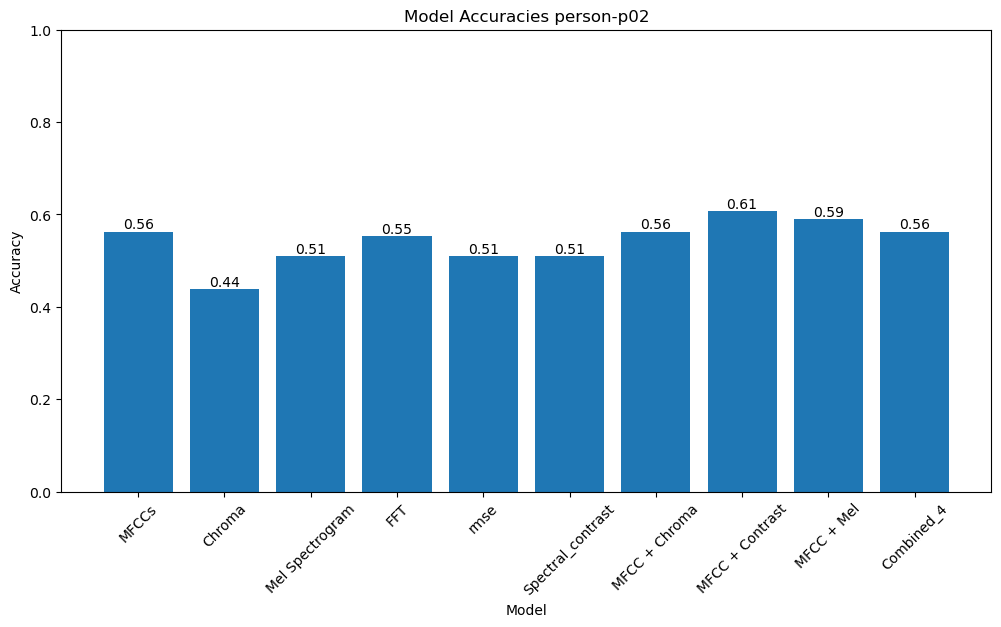

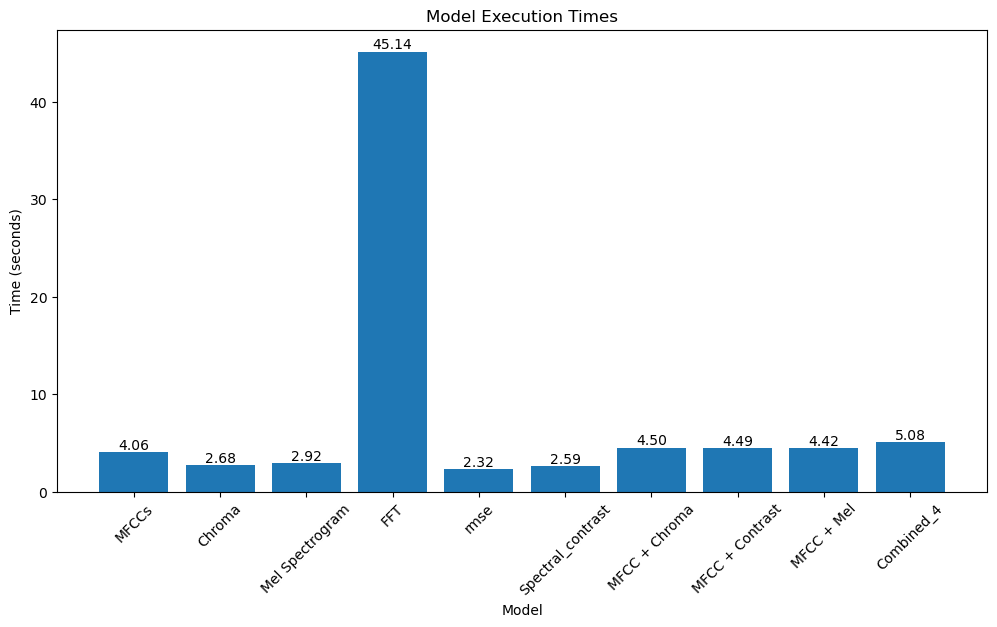

In [31]:

# Plot model accuracies
model_names = [
    "MFCCs", "Chroma", "Mel Spectrogram", "FFT","rmse","Spectral_contrast",
    "MFCC + Chroma", "MFCC + Contrast", "MFCC + Mel","Combined_4"
]

plt.figure(figsize=(12, 6))
bars = plt.bar(model_names, accuracy_stack)
plt.title("Model Accuracies person-p02")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.xticks(rotation=45)

# Annotate each bar with its accuracy value
for bar, accuracy in zip(bars, accuracy_stack):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{accuracy:.2f}', ha='center', va='bottom')

plt.show()
# Plot execution times
plt.figure(figsize=(12, 6))
bar1=plt.bar(model_names, execution_times)
plt.title("Model Execution Times")
plt.xlabel("Model")
plt.ylabel("Time (seconds)")
plt.xticks(rotation=45)
for bar1, time in zip(bar1, execution_times):
    plt.text(bar1.get_x() + bar1.get_width() / 2, bar1.get_height(), f'{time:.2f}', ha='center', va='bottom')

plt.show()
